# Impact of factors on retention

### Import libraries

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
#import geopandas as gpd

### Read in and process dependent variable

Read turnover data from csv into a dataframe.

In [33]:
# annual or monthly data
type = 'annual'
url = f'../01_data/processed_{type}_turnover.csv'
df = pd.read_csv(url, parse_dates=['month_year'])
df = df.drop(['n'],axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181008 entries, 0 to 181007
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   org_code     181008 non-null  object        
 1   region_name  181008 non-null  object        
 2   org_type     181008 non-null  object        
 3   staff_group  181008 non-null  object        
 4   month_year   181008 non-null  datetime64[ns]
 5   join_HC      136132 non-null  float64       
 6   join_FTE     136132 non-null  float64       
 7   leave_HC     138338 non-null  float64       
 8   leave_FTE    138338 non-null  float64       
 9   denom_HC     176695 non-null  float64       
 10  denom_FTE    176695 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 15.2+ MB


Calculate a leaver and joiner rate, drop HC columns

In [34]:
df['leaver_rate'] = df['leave_FTE']/df['denom_FTE']
df['joiner_rate'] = df['join_FTE']/df['denom_FTE']

df.replace([np.inf, -np.inf], np.nan, inplace=True)

df['leaver_rate'].fillna(0, inplace=True)
df['joiner_rate'].fillna(0, inplace=True)

df = df.drop(['join_HC','leave_HC','denom_HC'],axis=1)


In [35]:
df['staff_group'].unique()

array(['All staff groups', 'Ambulance staff', 'Central functions',
       'HCHS doctors (exc. junior Drs)', 'Hotel, property & estates',
       'Managers', 'Midwives', 'Nurses & health visitors',
       'Other staff or those with unknown classification',
       'Scientific, therapeutic & technical staff', 'Senior managers',
       'Support to ST&T staff', 'Support to doctors, nurses & midwives',
       'Support to ambulance staff'], dtype=object)

Drop 'All staff groups' - use sum of all others instead when wanting all staff.

In [36]:
df.drop(df[df['staff_group'] == 'All staff groups'].index, inplace = True)

Calculate a total staff in post (SIP; all staff) FTE column for each organisation by month.

In [37]:
# Group by 'date', 'organisation', and 'staff_group', then sum the FTE values
grouped_df = df.groupby(['month_year', 'org_code', 'staff_group'])['denom_FTE'].sum().reset_index()

# Group by 'date' and 'organisation' and sum the 'FTE' values for each group
total_sip_FTE = grouped_df.groupby(['month_year', 'org_code'])['denom_FTE'].sum().reset_index()

# Merge the total_sip_FTE DataFrame back into the original DataFrame using 'date' and 'organisation' as the keys
df = pd.merge(df, total_sip_FTE, on=['month_year', 'org_code'], suffixes=('', '_total'))

df.rename(columns={'denom_FTE_total': 'total_sip_FTE'}, inplace=True)

df.head()

,org_code,region_name,org_type,staff_group,month_year,join_FTE,leave_FTE,denom_FTE,leaver_rate,joiner_rate,total_sip_FTE
0,R0A,North West,Acute - Teaching,Ambulance staff,2020-02-01,NaN,NaN,1.00000,0.000000,0.000000,19970.15747
1,R0A,North West,Acute - Teaching,Central functions,2020-02-01,344.46002,188.60666,1659.63378,0.113644,0.207552,19970.15747
2,R0A,North West,Acute - Teaching,HCHS doctors (exc. junior Drs),2020-02-01,102.74834,68.70484,1253.83751,0.054796,0.081947,19970.15747
3,R0A,North West,Acute - Teaching,"Hotel, property & estates",2020-02-01,58.41334,22.42668,386.47879,0.058028,0.151142,19970.15747
4,R0A,North West,Acute - Teaching,Managers,2020-02-01,38.61351,15.48000,189.07166,0.081874,0.204227,19970.15747


In [38]:
# Calculate the percentage of staff group FTE by organization and date
df['%_FTE'] = df['denom_FTE'] / df['total_sip_FTE']

# Pivot the DataFrame to get staff groups as new columns with % values
pivot_df = df.pivot(index=['month_year', 'org_code'], columns='staff_group', values='%_FTE').reset_index()

# Merge the pivot DataFrame with the original DataFrame
df = pd.merge(df, pivot_df, on=['month_year', 'org_code'])

# Replace NaN values with zeros
#df.fillna(0, inplace=True)

# Print the updated DataFrame with % values for each staff group
df.head()

,org_code,region_name,org_type,staff_group,month_year,join_FTE,leave_FTE,denom_FTE,leaver_rate,joiner_rate,...,"Hotel, property & estates",Managers,Midwives,Nurses & health visitors,Other staff or those with unknown classification,"Scientific, therapeutic & technical staff",Senior managers,Support to ST&T staff,Support to ambulance staff,"Support to doctors, nurses & midwives"
0,R0A,North West,Acute - Teaching,Ambulance staff,2020-02-01,NaN,NaN,1.00000,0.000000,0.000000,...,0.019353,0.009468,0.024753,0.315781,0.000501,0.161369,0.007363,0.071334,NaN,0.244138
1,R0A,North West,Acute - Teaching,Central functions,2020-02-01,344.46002,188.60666,1659.63378,0.113644,0.207552,...,0.019353,0.009468,0.024753,0.315781,0.000501,0.161369,0.007363,0.071334,NaN,0.244138
2,R0A,North West,Acute - Teaching,HCHS doctors (exc. junior Drs),2020-02-01,102.74834,68.70484,1253.83751,0.054796,0.081947,...,0.019353,0.009468,0.024753,0.315781,0.000501,0.161369,0.007363,0.071334,NaN,0.244138
3,R0A,North West,Acute - Teaching,"Hotel, property & estates",2020-02-01,58.41334,22.42668,386.47879,0.058028,0.151142,...,0.019353,0.009468,0.024753,0.315781,0.000501,0.161369,0.007363,0.071334,NaN,0.244138
4,R0A,North West,Acute - Teaching,Managers,2020-02-01,38.61351,15.48000,189.07166,0.081874,0.204227,...,0.019353,0.009468,0.024753,0.315781,0.000501,0.161369,0.007363,0.071334,NaN,0.244138


The data show the full time equivalent (FTE) number of leavers by organisation and staff group for the previous 12-month period from the date. It also shows the number of staff in post (SIP) FTE averaged over the 12-month period to date.

Load data about local unemployment so we can use it as a regressor

In [39]:
url_r1 = '../01_data/ONS_localunemployment_monthly.csv'
df_r1 = pd.read_csv(url_r1, parse_dates=['Date'])

df_r1.tail()

,Date,Region,NHSE region name,%,thousands
3343,2023-03-01,North West,North West,0.030,107
3344,2023-03-01,South East,South East,0.037,177
3345,2023-03-01,South West,South West,0.031,89
3346,2023-03-01,West Midlands,Midlands,0.048,147
3347,2023-03-01,York & the Humber,North East and Yorkshire,0.038,104


In [40]:
df_r1.drop(['Region','thousands'],axis=1,inplace=True)
df_r1.rename(columns={'%':'local_unemployment','Date':'month_year',
                      'NHSE region name':'region_name'},inplace=True)
df_r1 = df_r1.sort_values('month_year')
df_r1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3348 entries, 0 to 3347
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   month_year          3348 non-null   datetime64[ns]
 1   region_name         3348 non-null   object        
 2   local_unemployment  3348 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 104.6+ KB


Add data about local unemployment at the regional level to the main dataframe

In [41]:
df_leaver_r1 = pd.merge(df, df_r1, on=['month_year', 'region_name'],how='left')
#df_leaver_r1 = df_leaver_r1.dropna()
df_leaver_r1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196538 entries, 0 to 196537
Data columns (total 26 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   org_code                                          196538 non-null  object        
 1   region_name                                       196538 non-null  object        
 2   org_type                                          196538 non-null  object        
 3   staff_group                                       196538 non-null  object        
 4   month_year                                        196538 non-null  datetime64[ns]
 5   join_FTE                                          146955 non-null  float64       
 6   leave_FTE                                         149331 non-null  float64       
 7   denom_FTE                                         191850 non-null  float64       
 8   leaver_rate   

In [42]:
df_leaver_r1 = df_leaver_r1.sort_values('month_year')
df_leaver_r1.tail()

,org_code,region_name,org_type,staff_group,month_year,join_FTE,leave_FTE,denom_FTE,leaver_rate,joiner_rate,...,Managers,Midwives,Nurses & health visitors,Other staff or those with unknown classification,"Scientific, therapeutic & technical staff",Senior managers,Support to ST&T staff,Support to ambulance staff,"Support to doctors, nurses & midwives",local_unemployment
75437,RLQ,Midlands,Acute - Multi-Service,Managers,2023-03-01,2.00000,5.80000,41.65334,0.139245,0.048015,...,0.013097,0.023922,0.276413,NaN,0.128186,0.008930,0.084785,0.000252,0.262411,0.048
75438,RLQ,Midlands,Acute - Multi-Service,Managers,2023-03-01,2.00000,5.80000,41.65334,0.139245,0.048015,...,0.013097,0.023922,0.276413,NaN,0.128186,0.008930,0.084785,0.000252,0.262411,0.034
75439,RLQ,Midlands,Acute - Multi-Service,Midwives,2023-03-01,11.46666,4.40000,76.07994,0.057834,0.150719,...,0.013097,0.023922,0.276413,NaN,0.128186,0.008930,0.084785,0.000252,0.262411,0.048
75441,RLQ,Midlands,Acute - Multi-Service,Nurses & health visitors,2023-03-01,125.84666,104.14667,879.08417,0.118472,0.143157,...,0.013097,0.023922,0.276413,NaN,0.128186,0.008930,0.084785,0.000252,0.262411,0.048
196537,TAJ,Midlands,Mental Health and Learning Disability,"Support to doctors, nurses & midwives",2023-03-01,165.90892,84.64213,860.73011,0.098338,0.192754,...,0.025495,NaN,0.293805,NaN,0.126865,0.016438,0.118463,NaN,0.249975,0.034


Load data about sickness absence to use as second regressor

In [43]:
url_r2 = '../01_data/sickness_absence.csv'
df_r2 = pd.read_csv(url_r2, parse_dates=['Date'])
trust_types_todrop = ['Clinical Commissioning Group','Integrated Care Board']
df_r2 = df_r2[~df_r2['Cluster group'].isin(trust_types_todrop)]
df_r2 = df_r2.drop(['Benchmark group','Org name',
                    'NHSE region code','Cluster group'],axis=1)
df_r2.rename(columns={'Org code':'org_code','Date':'month_year',
                      'NHSE region name':'region_name','Staff group':'staff_group'},inplace=True)
df_r2 = df_r2.reset_index(drop=True)
df_r2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241185 entries, 0 to 241184
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   month_year          241185 non-null  datetime64[ns]
 1   org_code            241185 non-null  object        
 2   region_name         241185 non-null  object        
 3   staff_group         241185 non-null  object        
 4   FTE days lost       241185 non-null  float64       
 5   FTE days available  241185 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 11.0+ MB


In [44]:
df_r2.tail()

,month_year,org_code,region_name,staff_group,FTE days lost,FTE days available
241180,2022-06-01,RRF,North West,Support to ST&T staff,436.00301,6546.33419
241181,2022-06-01,RVY,North West,"Hotel, property & estates",577.86664,8158.65161
241182,2022-06-01,RWE,Midlands,"Support to doctors, nurses & midwives",7081.34638,112685.24840
241183,2022-06-01,RWP,Midlands,Midwives,531.53824,6310.98954
241184,2022-06-01,RWK,London,Senior managers,38.00000,4882.41354


Add sickness absence data to the main dataframe

In [45]:
merge_cols = ['month_year', 'org_code','region_name','staff_group']
df_leaver_r2 = pd.merge(df_leaver_r1, df_r2, on=merge_cols,how='left')
#df_leaver_r2 = df_leaver_r2.dropna()
df_leaver_r2.drop_duplicates(subset=merge_cols)
df_leaver_r2.rename(columns={'FTE days lost':'fte_days_lost','FTE days available':'fte_days_available'},inplace=True)
df_leaver_r2['sickness_absence'] = df_leaver_r2['fte_days_lost']/df_leaver_r2['fte_days_available']
df_leaver_r2 = df_leaver_r2.drop(['fte_days_available'],axis=1)
df_leaver_r2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285182 entries, 0 to 285181
Data columns (total 28 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   org_code                                          285182 non-null  object        
 1   region_name                                       285182 non-null  object        
 2   org_type                                          285182 non-null  object        
 3   staff_group                                       285182 non-null  object        
 4   month_year                                        285182 non-null  datetime64[ns]
 5   join_FTE                                          221566 non-null  float64       
 6   leave_FTE                                         223586 non-null  float64       
 7   denom_FTE                                         280494 non-null  float64       
 8   leaver_rate   

Add data about reasons for sickness absence

In [46]:
url_r3 = '../01_data/sickness_absence_reason_pivot.csv'
df_r3 = pd.read_csv(url_r3, parse_dates=['Date'])
#df_r3 = df_r3.drop(['FTE days lost'],axis=1)
df_r3.rename(columns={'Date':'month_year','Staff group':'staff_group'},inplace=True)
#df_r2 = df_r2.reset_index(drop=True)

# drop least frequent reasons for absence
df_r3 = df_r3.drop(['substance_abus','asthma',
                    'dental','blood_disorder','endocrine',
                    'eye','skin_disorders','nervous_system'],axis=1)

# Replace NaN values with 0 
df_r3 = df_r3.fillna(0)
df_r3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374 entries, 0 to 1373
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   month_year         1374 non-null   datetime64[ns]
 1   staff_group        1374 non-null   object        
 2   anxiety_stress     1374 non-null   float64       
 3   back_problems      1374 non-null   float64       
 4   gastro             1374 non-null   float64       
 5   gynaecological     1374 non-null   float64       
 6   headache_mig       1374 non-null   float64       
 7   infectious_dis     1374 non-null   float64       
 8   other              1374 non-null   float64       
 9   other_msk          1374 non-null   float64       
 10  pregnancy_related  1374 non-null   float64       
 11  respiratory        1374 non-null   float64       
 12  unknown            1374 non-null   float64       
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 139.

Add sickness absence reason data to main dataframe

In [47]:
merge_cols = ['month_year','staff_group']
df_leaver_r3 = pd.merge(df_leaver_r2, df_r3, on=merge_cols,how='left')
#df_leaver_r2 = df_leaver_r2.dropna()
#df_leaver_r3.drop_duplicates(subset=merge_cols)
df_leaver_r3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285182 entries, 0 to 285181
Data columns (total 39 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   org_code                                          285182 non-null  object        
 1   region_name                                       285182 non-null  object        
 2   org_type                                          285182 non-null  object        
 3   staff_group                                       285182 non-null  object        
 4   month_year                                        285182 non-null  datetime64[ns]
 5   join_FTE                                          221566 non-null  float64       
 6   leave_FTE                                         223586 non-null  float64       
 7   denom_FTE                                         280494 non-null  float64       
 8   leaver_rate   

In [48]:
df_leaver_r3['month_year'].max()
#date_max = df['Date'].max()

Timestamp('2023-03-01 00:00:00')

In [49]:
# List of columns to replace NaN values with 0
#cols = ['local_unemployment','sickness_absence','leaver_rate','joiner_rate']

# Replace NaN values with 0 in the specified columns
#df_leaver_r3[cols] = df_leaver_r3[cols].fillna(0)
#Replace all NaN with 0
df_leaver_r3 = df_leaver_r3.fillna(0)

df_leaver_r3.reset_index(drop=True)
df_leaver_r3.head()

,org_code,region_name,org_type,staff_group,month_year,join_FTE,leave_FTE,denom_FTE,leaver_rate,joiner_rate,...,back_problems,gastro,gynaecological,headache_mig,infectious_dis,other,other_msk,pregnancy_related,respiratory,unknown
0,RCB,North East and Yorkshire,Acute - Teaching,"Hotel, property & estates",2017-08-01,0.0,0.0,627.58948,0.0,0.0,...,0.098038,0.102627,0.038417,0.017301,0.008168,0.124457,0.201008,0.012112,0.042741,0.066527
1,RXW,Midlands,Acute - Medium,Managers,2017-08-01,0.0,0.0,120.08000,0.0,0.0,...,0.044803,0.097362,0.031337,0.031637,0.007016,0.146584,0.057482,0.016664,0.024384,0.137439
2,RXW,Midlands,Acute - Medium,Midwives,2017-08-01,0.0,0.0,186.44239,0.0,0.0,...,0.067213,0.089435,0.066639,0.024907,0.008601,0.097594,0.139491,0.053051,0.024075,0.059241
3,RXW,Midlands,Acute - Medium,Midwives,2017-08-01,0.0,0.0,186.44239,0.0,0.0,...,0.067213,0.089435,0.066639,0.024907,0.008601,0.097594,0.139491,0.053051,0.024075,0.059241
4,RXW,Midlands,Acute - Medium,Nurses & health visitors,2017-08-01,0.0,0.0,1181.83932,0.0,0.0,...,0.073267,0.101870,0.053582,0.027108,0.006813,0.097913,0.144763,0.045536,0.028893,0.065937


Need to cut dataframe to earliest and latest data available for all fields. Do this by cutting rows where all values for key variables are zero

In [50]:
df_leaver_r3 = df_leaver_r3[~((df_leaver_r3['join_FTE'] == 0) | (df_leaver_r3['leave_FTE'] == 0) | (df_leaver_r3['sickness_absence'] == 0))]

#filtered_df = df[((df['col1'] == 0) & (df['col2'] == 0)) | ((df['col3'] == 0) & (df['col4'] == 0))]


In [51]:
df_leaver_r3.tail()

,org_code,region_name,org_type,staff_group,month_year,join_FTE,leave_FTE,denom_FTE,leaver_rate,joiner_rate,...,back_problems,gastro,gynaecological,headache_mig,infectious_dis,other,other_msk,pregnancy_related,respiratory,unknown
285177,RLQ,Midlands,Acute - Multi-Service,Managers,2023-03-01,2.00000,5.80000,41.65334,0.139245,0.048015,...,0.022413,0.068924,0.030542,0.028041,0.049080,0.127513,0.057015,0.006752,0.074477,0.064931
285178,RLQ,Midlands,Acute - Multi-Service,Managers,2023-03-01,2.00000,5.80000,41.65334,0.139245,0.048015,...,0.022413,0.068924,0.030542,0.028041,0.049080,0.127513,0.057015,0.006752,0.074477,0.064931
285179,RLQ,Midlands,Acute - Multi-Service,Midwives,2023-03-01,11.46666,4.40000,76.07994,0.057834,0.150719,...,0.033409,0.088291,0.051420,0.022050,0.076531,0.091532,0.099049,0.054606,0.066442,0.031839
285180,RLQ,Midlands,Acute - Multi-Service,Nurses & health visitors,2023-03-01,125.84666,104.14667,879.08417,0.118472,0.143157,...,0.046759,0.094432,0.044905,0.029868,0.084031,0.080937,0.096494,0.064840,0.080637,0.031185
285181,TAJ,Midlands,Mental Health and Learning Disability,"Support to doctors, nurses & midwives",2023-03-01,165.90892,84.64213,860.73011,0.098338,0.192754,...,0.054337,0.103057,0.038150,0.029438,0.070536,0.080392,0.120188,0.031478,0.079074,0.029342


In [52]:
#df_check = df_leaver_r2[['joiner_rate']]
#mask = np.isinf(df_check) | np.isnan(df_check)
#check = df_check[mask.any(axis=1)]

Add month of year as a variable

In [53]:
# Extract the month from the 'Date' column and create a new column
df_leaver_r3['month'] = df_leaver_r3['month_year'].dt.month

In [54]:
# Extract the month from the 'Date' column and create a new column
df_leaver_r3['year'] = df_leaver_r3['month_year'].dt.year

drop duplicate rows

In [55]:
 #de-duplicate
df_leaver_r3 = df_leaver_r3.drop_duplicates().reset_index()

Explore independent and dependent variables

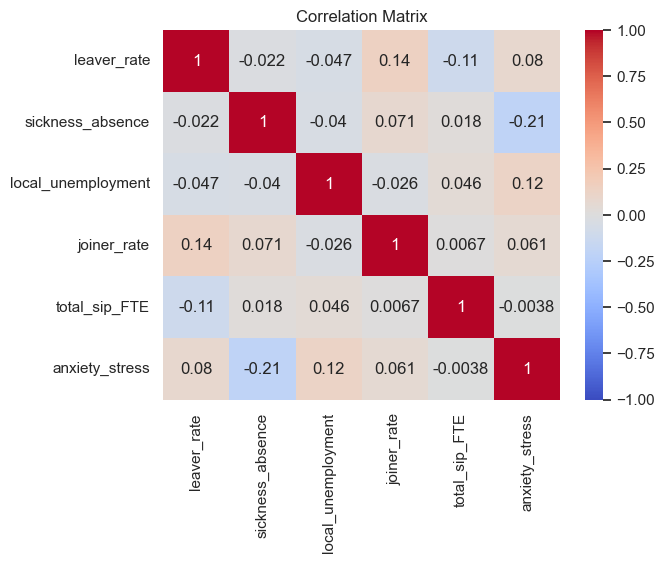

In [56]:
corr_cols = ['leaver_rate', 'sickness_absence',
                                   'local_unemployment','joiner_rate','total_sip_FTE','anxiety_stress']
correlation_matrix = df_leaver_r3[corr_cols].corr()
# Create correlation matrix heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Create a staff group level dataframe - specify which staff group you want from list below in variable staff_group

In [57]:
sorted(df_leaver_r3['staff_group'].unique())

['Ambulance staff',
 'Central functions',
 'HCHS doctors (exc. junior Drs)',
 'Hotel, property & estates',
 'Managers',
 'Midwives',
 'Nurses & health visitors',
 'Other staff or those with unknown classification',
 'Scientific, therapeutic & technical staff',
 'Senior managers',
 'Support to ST&T staff',
 'Support to ambulance staff',
 'Support to doctors, nurses & midwives']

In [58]:
staff_group = 'Nurses & health visitors'
df_sg = df_leaver_r3[df_leaver_r3['staff_group'] == staff_group].copy()

#df_sg['sickness_absence_rate'] = df_sg['FTE days lost']/df_sg['FTE days available']
#df_sg['leaver_rate'] = df_sg['leave_FTE']/df_sg['denom_FTE']

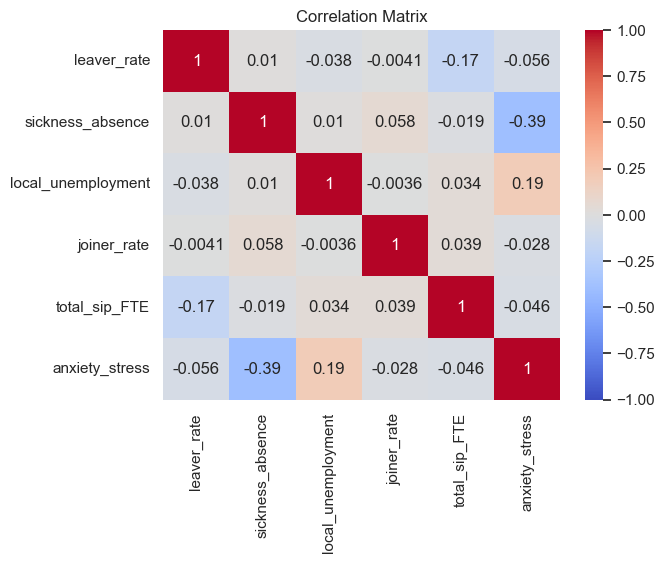

In [59]:
correlation_matrix = df_sg[corr_cols].corr()
# Create correlation matrix heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

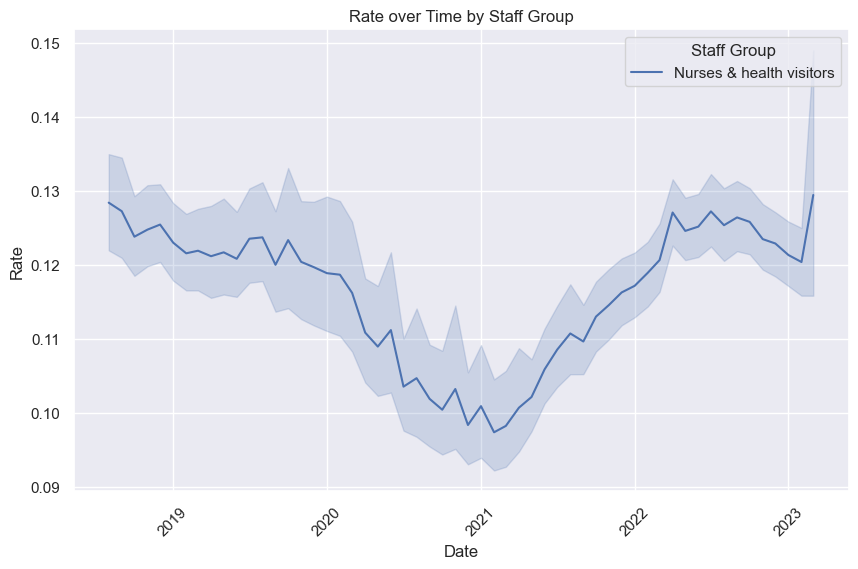

In [60]:
df_sg
sns.set()

plt.figure(figsize=(10, 6))  
sns.lineplot(data=df_sg, x='month_year', y='leaver_rate', hue='staff_group')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Rate over Time by Staff Group')
plt.legend(title='Staff Group', loc='best')  
plt.xticks(rotation=45)  
plt.show()

(Optional) Create dummy variables for categorical independent variables

In [61]:
#ivs_cat = ['region_name','staff_group']
#df_with_dummies = pd.get_dummies(df_m, columns=ivs_cat, drop_first=True)
#df_with_dummies.head()

In [62]:
df_leaver_r3.to_csv(f'annual_modelling_data.csv', index=False)

In [63]:
#df_sg.to_csv(f'sg_modelling_data_to_check.csv', index=False)


Specify the dependent variable (dv) and independent variables (ivs). All other fields to be dropped. 

In [64]:
dv = 'leaver_rate'
#ivs = ['local_unemployment','sickness_absence_rate','joiner_rate','sip_FTE']
to_drop = ['month_year','org_code','region_name','org_type','staff_group','%_FTE',
           'join_FTE','leave_FTE','denom_FTE','fte_days_lost','gastro','other','pregnancy_related', dv]

Define the design matrix (X) and the dependent variable (y)


In [65]:
df_leaver_r3.reset_index(drop = True)
X = df_leaver_r3.drop(to_drop, axis=1)
y = df_leaver_r3[dv]

#y = y.dropna()

y.head()


0    0.107967
1    0.107967
2    0.129749
3    0.434686
4    0.130332
Name: leaver_rate, dtype: float64

In [66]:

# Add a constant column to the design matrix
X = sm.add_constant(X)

X.tail()

# Convert True/False categories to integer 0/1
#bool_columns = X.select_dtypes(include='bool').columns
#X[bool_columns] = X[bool_columns].astype(int)


,const,index,joiner_rate,total_sip_FTE,Ambulance staff,Central functions,HCHS doctors (exc. junior Drs),"Hotel, property & estates",Managers,Midwives,...,anxiety_stress,back_problems,gynaecological,headache_mig,infectious_dis,other_msk,respiratory,unknown,month,year
128449,1.0,285177,0.048015,3180.33000,0.00065,0.099757,0.072510,0.029087,0.013097,0.023922,...,0.430227,0.022413,0.030542,0.028041,0.049080,0.057015,0.074477,0.064931,3,2023
128450,1.0,285178,0.048015,3180.33000,0.00065,0.099757,0.072510,0.029087,0.013097,0.023922,...,0.430227,0.022413,0.030542,0.028041,0.049080,0.057015,0.074477,0.064931,3,2023
128451,1.0,285179,0.150719,3180.33000,0.00065,0.099757,0.072510,0.029087,0.013097,0.023922,...,0.347314,0.033409,0.051420,0.022050,0.076531,0.099049,0.066442,0.031839,3,2023
128452,1.0,285180,0.143157,3180.33000,0.00065,0.099757,0.072510,0.029087,0.013097,0.023922,...,0.296121,0.046759,0.044905,0.029868,0.084031,0.096494,0.080637,0.031185,3,2023
128453,1.0,285181,0.192754,3443.25848,0.00000,0.080482,0.035639,0.052838,0.025495,0.000000,...,0.310589,0.054337,0.038150,0.029438,0.070536,0.120188,0.079074,0.029342,3,2023


In [67]:
# Fit the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            leaver_rate   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     415.5
Date:                Thu, 03 Aug 2023   Prob (F-statistic):               0.00
Time:                        16:30:07   Log-Likelihood:             1.5174e+05
No. Observations:              128454   AIC:                        -3.034e+05
Df Residuals:                  128426   BIC:                        -3.031e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [68]:

# Get the summary of the regression results
summary = results.summary()

# # Convert the summary table to a pandas DataFrame
# summary_df = pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

# # Format the coefficients and p-values
# summary_df['coef'] = summary_df['coef'].map('{:.4f}'.format)
# summary_df['P>|t|'] = summary_df['P>|t|'].map('{:.4f}'.format)

# Print the formatted summary table
print(summary.tables[1])

                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                              -89.7939      2.370    -37.894      0.000     -94.438     -85.149
index                                            -9.136e-07   2.61e-08    -35.004      0.000   -9.65e-07   -8.62e-07
joiner_rate                                          0.1000      0.002     40.725      0.000       0.095       0.105
total_sip_FTE                                    -2.209e-06   6.97e-08    -31.670      0.000   -2.35e-06   -2.07e-06
Ambulance staff                                     -7.0254      0.182    -38.558      0.000      -7.383      -6.668
Central functions                                   -7.0075      0.182    -38.582      0.000      -7.363      -6.652
HCHS doctors (exc. junior Drs)                      -6.9699     